<a href="https://colab.research.google.com/github/AaronM44/DAOTW-Assignment-1/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


## Linear Regression

### Simple Linear Regression

#### Read Data

##### Training Data

In [4]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/col_mod_1_train.csv"

raw_col_mod_train_1 = pd.read_csv(url)

df_col_mod_train_1 = raw_col_mod_train_1.copy()

df_col_mod_train_1 = df_col_mod_train_1.drop(df_col_mod_train_1.columns[[0, 1]], axis=1)

df_col_mod_train_1.head()

,year,mo,day,temp,visib,num_collisions
0,2017,2,1,5.5,10.0,428
1,2014,4,1,8.1,10.0,597
2,2018,1,1,1.7,9.9,720
3,2019,4,3,8.6,10.0,621
4,2016,12,2,5.4,10.0,711


##### Test Data

In [5]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/col_mod_1_test.csv"

raw_col_mod_test_1 = pd.read_csv(url)

df_col_mod_test_1 = raw_col_mod_test_1.copy()

df_col_mod_test_1 = df_col_mod_test_1.drop(df_col_mod_test_1.columns[[0, 1]], axis=1)

df_col_mod_test_1.head()

,year,mo,day,temp,visib,num_collisions
0,2013,1,4,-5.7,10.0,549
1,2013,1,6,2.9,10.0,389
2,2013,1,5,3.3,10.0,660
3,2013,1,2,5.7,9.5,516
4,2013,1,3,5.3,7.0,578


#### Check for NAs

In [6]:
df_col_mod_train_1.isna().sum()

year              0
mo                0
day               0
temp              0
visib             0
num_collisions    0
dtype: int64

#### Overview of data

In [7]:
df_col_mod_train_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,1766.0,2016.017554,2.019797,2013.0,2014.000,2016.0,2018.00,2019.0
mo,1766.0,6.505663,3.432674,1.0,4.000,7.0,9.00,12.0
day,1766.0,4.016421,1.996672,1.0,2.000,4.0,6.00,7.0
temp,1766.0,10.883126,7.838086,-12.6,4.700,11.2,17.70,25.2
visib,1766.0,8.307418,2.195294,0.2,7.025,9.4,10.00,10.0
num_collisions,1766.0,599.751416,95.446688,355.0,532.000,601.0,665.75,845.0


#### Separate Features and Labels

In [8]:
df_col_mod_train_1_feat = df_col_mod_train_1.copy()
df_col_mod_test_1_feat = df_col_mod_test_1.copy()

df_col_mod_train_1_lab = df_col_mod_train_1_feat.pop('num_collisions')
df_col_mod_test_1_lab = df_col_mod_test_1_feat.pop('num_collisions')

#### Create Model

Starting with a single variable to get a baseline using temperature as the independent variable.

##### Create Normaliser Layer

In [9]:
normaliser = tf.keras.layers.Normalization(axis=-1)

normaliser.adapt(np.array(df_col_mod_train_1_feat))

print(normaliser.mean.numpy())

[[2016.018    6.506    4.016   10.883    8.307]]


##### Sequencer

In [10]:
temp = np.array(df_col_mod_train_1_feat['temp'])

temp_normaliser = layers.Normalization(input_shape=[1,], axis=None)
temp_normaliser.adapt(temp)

In [11]:
temp_model = tf.keras.Sequential([
    temp_normaliser,
    layers.Dense(units=1)
])

temp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


First ten records

In [12]:
temp_model.predict(temp[:10])

1/1 [==============================] - 0s 292ms/step


array([[ 0.344],
       [ 0.178],
       [ 0.587],
       [ 0.146],
       [ 0.351],
       [ 0.063],
       [ 0.799],
       [ 0.05 ],
       [ 0.639],
       [-0.564]], dtype=float32)

Configure training procedure

In [13]:
temp_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Execute model for 100 epochs

In [14]:
%%time
history = temp_model.fit(
    df_col_mod_train_1_feat['temp'],
    df_col_mod_train_1_lab,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 12 s, sys: 484 ms, total: 12.5 s
Wall time: 21.2 s


Visualise progress

In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,175.500259,178.944229,95
96,171.556580,174.951218,96
97,167.620453,170.938217,97
98,163.756805,166.966507,98
99,159.906067,163.095642,99


Plot history

In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [num_collisions]')
  plt.legend()
  plt.grid(True)

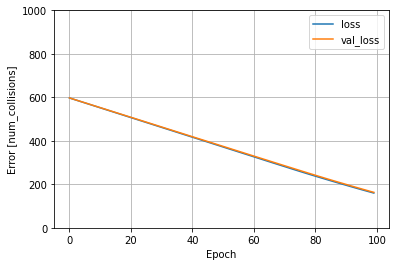

In [17]:
plot_loss(history)

Collect test results

In [18]:
test_results = {}

test_results['temp_model'] = temp_model.evaluate(
    df_col_mod_test_1_feat['temp'],
    df_col_mod_test_1_lab, verbose=0)

In [19]:
print(test_results)

{'temp_model': 155.27452087402344}


View predictions as a function of the input

In [20]:
x = tf.linspace(0.0, 30, 31)
y = temp_model.predict(x)

1/1 [==============================] - 0s 61ms/step


In [21]:
def plot_temp(x, y):
  plt.scatter(df_col_mod_train_1_feat['temp'], df_col_mod_train_1_lab, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Temperature')
  plt.ylabel('Num. Collisions')
  plt.legend()

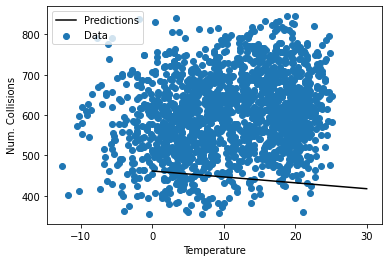

In [22]:
plot_temp(x, y)

### Non-Standardised without One-Hot Encoding

normaliser

In [23]:
col_mod_1_normaliser = tf.keras.layers.Normalization(axis=-1)

normaliser.adapt(np.array(df_col_mod_train_1_feat))

print(normaliser.mean.numpy())

[[2016.018    6.506    4.016   10.883    8.307]]


sequencer

In [24]:
col_mod_1 = np.array(df_col_mod_train_1_feat)

col_mod_1_normaliser = layers.Normalization(axis=-1)
col_mod_1_normaliser.adapt(np.array(df_col_mod_train_1_feat))

In [25]:
col_mod_1_model = tf.keras.Sequential([
    col_mod_1_normaliser,
    layers.Dense(units=1)
])

col_mod_1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 17
Trainable params: 6
Non-trainable params: 11
_________________________________________________________________


In [26]:
col_mod_1_model.predict(col_mod_1)

56/56 [==============================] - 0s 1ms/step


array([[-3.225],
       [-1.935],
       [-3.998],
       ...,
       [ 0.217],
       [ 3.221],
       [ 2.378]], dtype=float32)

In [27]:
col_mod_1_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[-0.339],
       [ 0.989],
       [ 0.994],
       [ 0.632],
       [ 0.225]], dtype=float32)>

In [28]:
col_mod_1_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [29]:
%%time
history = col_mod_1_model.fit(
    df_col_mod_train_1_feat,
    df_col_mod_train_1_lab,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 9.2 s, sys: 555 ms, total: 9.75 s
Wall time: 10.6 s


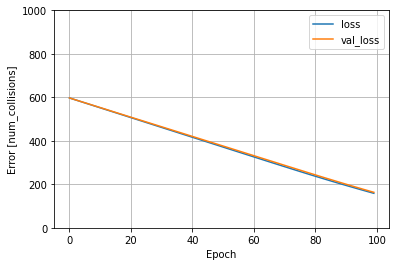

In [30]:
plot_loss(history)

In [31]:
test_results['col_mod_1'] = col_mod_1_model.evaluate(
    df_col_mod_test_1_feat,
    df_col_mod_test_1_lab, verbose=0)

In [32]:
print(test_results)

{'temp_model': 155.27452087402344, 'col_mod_1': 154.217529296875}


### Standardised with One-Hot Encoding

#### Read Data

##### Training Data

In [33]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/std_col_mod_1_train.csv"

raw_std_col_mod_train_1 = pd.read_csv(url)

df_std_col_mod_train_1 = raw_std_col_mod_train_1.copy()

df_std_col_mod_train_1 = df_std_col_mod_train_1.drop(df_std_col_mod_train_1.columns[[0, 1]], axis=1)

df_std_col_mod_train_1.head()

,year,mo,day,temp,visib,num_collisions
0,2016,11,7,-0.026584,0.769518,518
1,2013,1,6,-1.111048,0.406393,484
2,2015,6,7,0.904779,-1.817748,535
3,2014,9,5,0.394443,0.769518,648
4,2013,4,7,-0.396577,0.587955,472


##### Test Data

In [34]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/std_col_mod_1_test.csv"

raw_std_col_mod_test_1 = pd.read_csv(url)

df_std_col_mod_test_1 = raw_std_col_mod_test_1.copy()

df_std_col_mod_test_1 = df_std_col_mod_test_1.drop(df_std_col_mod_test_1.columns[[0, 1]], axis=1)

df_std_col_mod_test_1.head()

,year,mo,day,temp,visib,num_collisions
0,2013,1,4,-2.118962,0.769518,549
1,2013,1,5,-1.378974,0.769518,505
2,2013,1,3,-0.830363,-0.682982,487
3,2013,1,5,-1.672417,-0.365248,561
4,2013,1,1,-1.442766,0.406393,355


#### Check for NAs

In [35]:
df_std_col_mod_train_1.isna().sum()

year              0
mo                0
day               0
temp              0
visib             0
num_collisions    0
dtype: int64

#### Overview of Data

In [36]:
df_std_col_mod_train_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,1766.0,2015.989241,1.988465,2013.000000,2014.000000,2016.000000,2018.000000,2019.000000
mo,1766.0,6.513590,3.382774,1.000000,4.000000,7.000000,9.000000,12.000000
day,1766.0,4.000566,1.995888,1.000000,2.000000,4.000000,6.000000,7.000000
temp,1766.0,0.028546,1.002625,-2.999291,-0.728296,0.075483,0.927107,1.823384
visib,1766.0,0.001784,0.997481,-3.678763,-0.546810,0.497174,0.769518,0.769518
num_collisions,1766.0,597.920725,93.093504,355.000000,533.000000,603.000000,660.000000,841.000000


#### Separate Features and Labels

In [37]:
df_std_col_mod_train_1_feat = df_std_col_mod_train_1.copy()
df_std_col_mod_test_1_feat = df_std_col_mod_test_1.copy()

df_std_col_mod_train_1_lab = df_std_col_mod_train_1_feat.pop('num_collisions')
df_std_col_mod_test_1_lab = df_std_col_mod_test_1_feat.pop('num_collisions')

#### Model

##### Normaliser Layer

In [38]:
normaliser = tf.keras.layers.Normalization(axis=-1)

normaliser.adapt(np.array(df_std_col_mod_train_1_feat))

print(normaliser.mean.numpy())

[[2015.989    6.514    4.001    0.029    0.002]]


##### Sequencer

In [39]:
std_col_mod_1 = np.array(df_std_col_mod_train_1_feat)

std_col_mod_1_normaliser = layers.Normalization(axis=-1)
std_col_mod_1_normaliser.adapt(np.array(df_std_col_mod_train_1_feat))

In [40]:
std_col_mod_1_model = tf.keras.Sequential([
    std_col_mod_1_normaliser,
    layers.Dense(units=1)
])

std_col_mod_1_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 17
Trainable params: 6
Non-trainable params: 11
_________________________________________________________________


In [41]:
std_col_mod_1_model.predict(std_col_mod_1)

56/56 [==============================] - 0s 1ms/step


array([[-1.843],
       [-0.336],
       [-1.335],
       ...,
       [ 0.978],
       [ 0.491],
       [-0.376]], dtype=float32)

In [42]:
std_col_mod_1_model.layers[1].kernel

<tf.Variable 'dense_2/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[ 0.287],
       [-0.09 ],
       [-0.906],
       [-0.945],
       [-0.538]], dtype=float32)>

In [43]:
std_col_mod_1_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [44]:
%%time
history = std_col_mod_1_model.fit(
    df_std_col_mod_train_1_feat,
    df_std_col_mod_train_1_lab,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 9.16 s, sys: 482 ms, total: 9.64 s
Wall time: 8.68 s


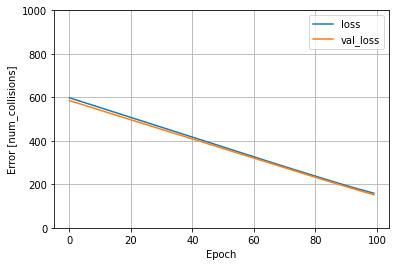

In [45]:
plot_loss(history)

In [46]:
test_results['std_col_mod_1'] = std_col_mod_1_model.evaluate(
    df_std_col_mod_test_1_feat,
    df_std_col_mod_test_1_lab, verbose=0)

In [47]:
print(test_results)

{'temp_model': 155.27452087402344, 'col_mod_1': 154.217529296875, 'std_col_mod_1': 161.0737762451172}


### Normalised Data without One-Hot Encoding

#### Read Data

##### Training Data

In [48]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/norm_col_mod_1_train.csv"

raw_norm_col_mod_train_1 = pd.read_csv(url)

df_norm_col_mod_train_1 = raw_norm_col_mod_train_1.copy()

df_norm_col_mod_train_1 = df_norm_col_mod_train_1.drop(df_norm_col_mod_train_1.columns[[0, 1]], axis=1)

df_norm_col_mod_train_1.head()

,year,mo,day,temp,visib,num_collisions
0,2013,10,7,0.659631,1.000000,512
1,2019,7,4,0.839050,0.622449,394
2,2018,3,4,0.393140,0.653061,760
3,2013,1,1,0.263852,0.877551,507
4,2015,6,3,0.641161,1.000000,658


##### Test Data

In [49]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/rnom_col_mod_1_test.csv"

raw_norm_col_mod_test_1 = pd.read_csv(url)

df_norm_col_mod_test_1 = raw_norm_col_mod_test_1.copy()

df_norm_col_mod_test_1 = df_norm_col_mod_test_1.drop(df_norm_col_mod_test_1.columns[[0, 1]], axis=1)

df_norm_col_mod_test_1.head()

,year,mo,day,temp,visib,num_collisions
0,2013,1,1,0.554090,0.112245,542
1,2013,1,2,0.248021,0.642857,544
2,2013,1,4,0.073879,1.000000,554
3,2013,1,2,0.382586,0.244898,542
4,2013,1,4,0.546174,0.581633,592


#### Check for NAs

In [50]:
df_norm_col_mod_train_1.isna().sum()

year              0
mo                0
day               0
temp              0
visib             0
num_collisions    0
dtype: int64

#### Overview of Data

In [51]:
df_norm_col_mod_train_1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,1766.0,2015.962061,2.021479,2013.0,2014.000000,2016.000000,2018.000000,2019.0
mo,1766.0,6.456399,3.435042,1.0,3.000000,6.000000,9.000000,12.0
day,1766.0,4.005096,1.992757,1.0,2.000000,4.000000,6.000000,7.0
temp,1766.0,0.619183,0.206818,0.0,0.456464,0.626649,0.799472,1.0
visib,1766.0,0.827056,0.226572,0.0,0.704082,0.938776,1.000000,1.0
num_collisions,1766.0,597.340883,96.245180,355.0,528.000000,599.000000,662.000000,845.0


#### Separate Features and Labels

In [52]:
df_norm_col_mod_train_1_feat = df_norm_col_mod_train_1.copy()
df_norm_col_mod_test_1_feat = df_norm_col_mod_test_1.copy()

df_norm_col_mod_train_1_lab = df_norm_col_mod_train_1_feat.pop('num_collisions')
df_norm_col_mod_test_1_lab = df_norm_col_mod_test_1_feat.pop('num_collisions')

#### Model

##### Normaliser Layer

In [53]:
normaliser = tf.keras.layers.Normalization(axis=-1)

normaliser.adapt(np.array(df_norm_col_mod_train_1_feat))

print(normaliser.mean.numpy())

[[2015.962    6.456    4.005    0.619    0.827]]


##### Sequencer

In [54]:
norm_col_mod_1 = np.array(df_norm_col_mod_train_1_feat)

norm_col_mod_1_normaliser = layers.Normalization(axis=-1)
norm_col_mod_1_normaliser.adapt(np.array(df_norm_col_mod_train_1_feat))

In [55]:
norm_col_mod_1_model = tf.keras.Sequential([
    norm_col_mod_1_normaliser,
    layers.Dense(units=1)
])

norm_col_mod_1_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 17
Trainable params: 6
Non-trainable params: 11
_________________________________________________________________


In [56]:
norm_col_mod_1_model.predict(norm_col_mod_1)

56/56 [==============================] - 0s 1ms/step


array([[-0.563],
       [-0.984],
       [ 0.33 ],
       ...,
       [-0.844],
       [-0.295],
       [-1.036]], dtype=float32)

In [57]:
norm_col_mod_1_model.layers[1].kernel

<tf.Variable 'dense_3/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[ 0.329],
       [ 0.215],
       [-0.506],
       [-0.751],
       [ 0.791]], dtype=float32)>

In [58]:
norm_col_mod_1_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [59]:
%%time
history = norm_col_mod_1_model.fit(
    df_norm_col_mod_train_1_feat,
    df_norm_col_mod_train_1_lab,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 9.4 s, sys: 548 ms, total: 9.95 s
Wall time: 10.6 s


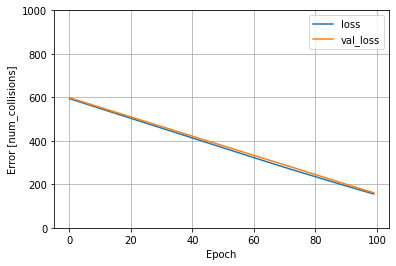

In [60]:
plot_loss(history)

In [61]:
test_results['norm_col_mod_1'] = norm_col_mod_1_model.evaluate(
    df_norm_col_mod_test_1_feat,
    df_norm_col_mod_test_1_lab, verbose=0)

In [62]:
print(test_results)

{'temp_model': 155.27452087402344, 'col_mod_1': 154.217529296875, 'std_col_mod_1': 161.0737762451172, 'norm_col_mod_1': 158.41468811035156}


### Non-Standardised Data with One-Hot Encoding

#### Read Data

##### Training Data

In [63]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/col_mod_2_train.csv"

raw_col_mod_train_2 = pd.read_csv(url)

df_col_mod_train_2 = raw_col_mod_train_2.copy()

df_col_mod_train_2 = df_col_mod_train_2.drop(df_col_mod_train_2.columns[[0, 1]], axis=1)

df_col_mod_train_2.head()

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,...,mon,tue,wed,thu,fri,sat,sun,temp,visib,num_collisions
0,2017,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,8.2,5.7,551
1,2017,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,-6.1,4.9,462
2,2014,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,11.2,6.5,666
3,2018,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,18.0,8.0,529
4,2016,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,15.2,10.0,652


##### Test Data

In [64]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/col_mod_2_test.csv"

raw_col_mod_test_2 = pd.read_csv(url)

df_col_mod_test_2 = raw_col_mod_test_2.copy()

df_col_mod_test_2 = df_col_mod_test_2.drop(df_col_mod_test_2.columns[[0, 1]], axis=1)

df_col_mod_test_2.head()

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,...,mon,tue,wed,thu,fri,sat,sun,temp,visib,num_collisions
0,2013,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,-2.5,10.0,480
1,2013,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0.1,10.0,505
2,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2.2,8.8,521
3,2013,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,3.3,10.0,660
4,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,5.9,7.1,475


#### Check for NAs

In [65]:
df_col_mod_train_2.isna().sum()

year              0
jan               0
feb               0
mar               0
apr               0
may               0
jun               0
jul               0
aug               0
sep               0
oct               0
nov               0
dec               0
mon               0
tue               0
wed               0
thu               0
fri               0
sat               0
sun               0
temp              0
visib             0
num_collisions    0
dtype: int64

#### Overview of Data

In [66]:
df_col_mod_train_2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,1766.0,2016.032843,2.003410,2013.0,2014.00,2016.0,2018.0,2019.0
jan,1766.0,0.082673,0.275465,0.0,0.00,0.0,0.0,1.0
feb,1766.0,0.080974,0.272872,0.0,0.00,0.0,0.0,1.0
mar,1766.0,0.082673,0.275465,0.0,0.00,0.0,0.0,1.0
apr,1766.0,0.087769,0.283039,0.0,0.00,0.0,0.0,1.0
may,1766.0,0.086636,0.281381,0.0,0.00,0.0,0.0,1.0
jun,1766.0,0.083805,0.277174,0.0,0.00,0.0,0.0,1.0
jul,1766.0,0.087203,0.282212,0.0,0.00,0.0,0.0,1.0
aug,1766.0,0.087769,0.283039,0.0,0.00,0.0,0.0,1.0
sep,1766.0,0.077576,0.267580,0.0,0.00,0.0,0.0,1.0


#### Separate Features and Labels

In [67]:
df_col_mod_train_2_feat = df_col_mod_train_2.copy()
df_col_mod_test_2_feat = df_col_mod_test_2.copy()

df_col_mod_train_2_lab = df_col_mod_train_2_feat.pop('num_collisions')
df_col_mod_test_2_lab = df_col_mod_test_2_feat.pop('num_collisions')

#### Model

##### Normaliser Layer

In [68]:
normaliser = tf.keras.layers.Normalization(axis=-1)

normaliser.adapt(np.array(df_col_mod_train_2_feat))

print(normaliser.mean.numpy())

[[2016.033    0.083    0.081    0.083    0.088    0.087    0.084    0.087
     0.088    0.078    0.09     0.078    0.075    0.143    0.143    0.143
     0.146    0.142    0.146    0.137   10.914    8.304]]


##### Sequencer

In [69]:
col_mod_2 = np.array(df_col_mod_train_2_feat)

col_mod_2_normaliser = layers.Normalization(axis=-1)
col_mod_2_normaliser.adapt(np.array(df_col_mod_train_2_feat))

In [70]:
col_mod_2_model = tf.keras.Sequential([
    col_mod_2_normaliser,
    layers.Dense(units=1)
])

col_mod_2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normalizat  (None, 22)               45        
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 23        
                                                                 
Total params: 68
Trainable params: 23
Non-trainable params: 45
_________________________________________________________________


In [71]:
col_mod_2_model.predict(col_mod_2)

56/56 [==============================] - 0s 1ms/step


array([[-1.825],
       [ 0.874],
       [ 2.559],
       ...,
       [-0.994],
       [ 2.73 ],
       [-0.726]], dtype=float32)

In [72]:
col_mod_2_model.layers[1].kernel

<tf.Variable 'dense_4/kernel:0' shape=(22, 1) dtype=float32, numpy=
array([[-0.399],
       [-0.425],
       [-0.459],
       [ 0.206],
       [-0.5  ],
       [ 0.15 ],
       [-0.066],
       [ 0.097],
       [-0.087],
       [-0.26 ],
       [-0.42 ],
       [ 0.433],
       [-0.175],
       [-0.383],
       [ 0.421],
       [-0.056],
       [ 0.057],
       [ 0.399],
       [-0.384],
       [ 0.193],
       [-0.426],
       [ 0.464]], dtype=float32)>

In [73]:
col_mod_2_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [74]:
%%time
history = col_mod_2_model.fit(
    df_col_mod_train_2_feat,
    df_col_mod_train_2_lab,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 9.08 s, sys: 488 ms, total: 9.57 s
Wall time: 8.61 s


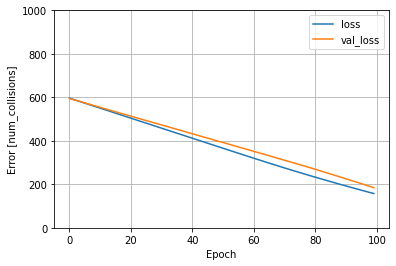

In [75]:
plot_loss(history)

In [76]:
test_results['col_mod_2'] = col_mod_2_model.evaluate(
    df_col_mod_test_2_feat,
    df_col_mod_test_2_lab, verbose=0)

In [77]:
print(test_results)

{'temp_model': 155.27452087402344, 'col_mod_1': 154.217529296875, 'std_col_mod_1': 161.0737762451172, 'norm_col_mod_1': 158.41468811035156, 'col_mod_2': 167.04177856445312}


### Standardised Data with One-Hot Encoding

#### Read Data

##### Training Data

In [78]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/std_col_mod_2_train.csv"

raw_std_col_mod_train_2 = pd.read_csv(url)

df_std_col_mod_train_2 = raw_std_col_mod_train_2.copy()

df_std_col_mod_train_2 = df_std_col_mod_train_2.drop(df_std_col_mod_train_2.columns[[0, 1]], axis=1)

df_std_col_mod_train_2.head()

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,...,mon,tue,wed,thu,fri,sat,sun,temp,visib,num_collisions
0,2017,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1.249256,-1.136888,515
1,2016,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,-0.396577,0.769518,517
2,2014,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,-0.830363,0.769518,622
3,2019,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0.981330,-0.955326,689
4,2013,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,-0.141409,0.724127,598


##### Test Data

In [79]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/std_col_mod_2_test.csv"

raw_std_col_mod_test_2 = pd.read_csv(url)

df_std_col_mod_test_2 = raw_std_col_mod_test_2.copy()

df_std_col_mod_test_2 = df_std_col_mod_test_2.drop(df_std_col_mod_test_2.columns[[0, 1]], axis=1)

df_std_col_mod_test_2.head()

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,...,mon,tue,wed,thu,fri,sat,sun,temp,visib,num_collisions
0,2013,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,-2.118962,0.769518,549
1,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,-1.021739,0.769518,389
2,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,-1.123806,0.678736,393
3,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,-0.638987,-0.546810,475
4,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,-0.664504,0.542565,516


#### Check for NAs

In [80]:
df_std_col_mod_train_2.isna().sum()

year              0
jan               0
feb               0
mar               0
apr               0
may               0
jun               0
jul               0
aug               0
sep               0
oct               0
nov               0
dec               0
mon               0
tue               0
wed               0
thu               0
fri               0
sat               0
sun               0
temp              0
visib             0
num_collisions    0
dtype: int64

#### Overview of Data

In [81]:
df_std_col_mod_train_2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,1766.0,2015.959230,2.028838,2013.000000,2014.000000,2016.000000,2018.000000,2019.000000
jan,1766.0,0.082673,0.275465,0.000000,0.000000,0.000000,0.000000,1.000000
feb,1766.0,0.075878,0.264877,0.000000,0.000000,0.000000,0.000000,1.000000
mar,1766.0,0.085504,0.279709,0.000000,0.000000,0.000000,0.000000,1.000000
apr,1766.0,0.086070,0.280547,0.000000,0.000000,0.000000,0.000000,1.000000
may,1766.0,0.087769,0.283039,0.000000,0.000000,0.000000,0.000000,1.000000
jun,1766.0,0.078709,0.269360,0.000000,0.000000,0.000000,0.000000,1.000000
jul,1766.0,0.088335,0.283862,0.000000,0.000000,0.000000,0.000000,1.000000
aug,1766.0,0.090600,0.287121,0.000000,0.000000,0.000000,0.000000,1.000000
sep,1766.0,0.077576,0.267580,0.000000,0.000000,0.000000,0.000000,1.000000


#### Separate Features and Labels

In [82]:
df_std_col_mod_train_2_feat = df_std_col_mod_train_2.copy()
df_std_col_mod_test_2_feat = df_std_col_mod_test_2.copy()

df_std_col_mod_train_2_lab = df_std_col_mod_train_2_feat.pop('num_collisions')
df_std_col_mod_test_2_lab = df_std_col_mod_test_2_feat.pop('num_collisions')

#### Model

##### Normaliser Layer

In [83]:
normaliser = tf.keras.layers.Normalization(axis=-1)

normaliser.adapt(np.array(df_std_col_mod_train_2_feat))

print(normaliser.mean.numpy())

[[2015.959    0.083    0.076    0.086    0.086    0.088    0.079    0.088
     0.091    0.078    0.081    0.083    0.083    0.148    0.147    0.14
     0.143    0.134    0.139    0.148   -0.002   -0.002]]


##### Sequencer

In [84]:
std_col_mod_2 = np.array(df_std_col_mod_train_2_feat)

std_col_mod_2_normaliser = layers.Normalization(axis=-1)
std_col_mod_2_normaliser.adapt(np.array(df_std_col_mod_train_2_feat))

In [85]:
std_col_mod_2_model = tf.keras.Sequential([
    std_col_mod_2_normaliser,
    layers.Dense(units=1)
])

std_col_mod_2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_11 (Normaliza  (None, 22)               45        
 tion)                                                           
                                                                 
 dense_5 (Dense)             (None, 1)                 23        
                                                                 
Total params: 68
Trainable params: 23
Non-trainable params: 45
_________________________________________________________________


In [86]:
std_col_mod_2_model.predict(std_col_mod_2)

56/56 [==============================] - 0s 1ms/step


array([[ 0.128],
       [ 0.731],
       [ 0.616],
       ...,
       [ 0.274],
       [-0.637],
       [-0.111]], dtype=float32)

In [87]:
std_col_mod_2_model.layers[1].kernel

<tf.Variable 'dense_5/kernel:0' shape=(22, 1) dtype=float32, numpy=
array([[ 0.153],
       [ 0.459],
       [-0.491],
       [ 0.191],
       [ 0.119],
       [-0.231],
       [-0.137],
       [ 0.106],
       [-0.079],
       [-0.003],
       [-0.051],
       [ 0.084],
       [-0.108],
       [ 0.002],
       [-0.318],
       [ 0.054],
       [ 0.173],
       [-0.227],
       [-0.195],
       [-0.017],
       [-0.083],
       [-0.176]], dtype=float32)>

In [88]:
std_col_mod_2_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [89]:
%%time
history = std_col_mod_2_model.fit(
    df_std_col_mod_train_2_feat,
    df_std_col_mod_train_2_lab,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 9.09 s, sys: 502 ms, total: 9.59 s
Wall time: 8.58 s


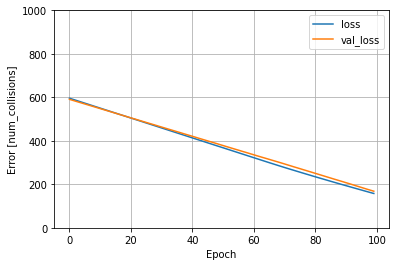

In [90]:
plot_loss(history)

In [91]:
test_results['std_col_mod_2'] = std_col_mod_2_model.evaluate(
    df_std_col_mod_test_2_feat,
    df_std_col_mod_test_2_lab, verbose=0)

In [92]:
print(test_results)

{'temp_model': 155.27452087402344, 'col_mod_1': 154.217529296875, 'std_col_mod_1': 161.0737762451172, 'norm_col_mod_1': 158.41468811035156, 'col_mod_2': 167.04177856445312, 'std_col_mod_2': 165.54393005371094}


### Normalised Data with One-Hot Encoding

### Read Data

##### Training Data

In [93]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/norm_col_mod_2_train.csv"

raw_norm_col_mod_train_2 = pd.read_csv(url)

df_norm_col_mod_train_2 = raw_norm_col_mod_train_2.copy()

df_norm_col_mod_train_2 = df_norm_col_mod_train_2.drop(df_norm_col_mod_train_2.columns[[0, 1]], axis=1)

df_norm_col_mod_train_2.head()

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,...,mon,tue,wed,thu,fri,sat,sun,temp,visib,num_collisions
0,2016,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.269129,0.785714,640
1,2014,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0.614776,1.000000,668
2,2014,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0.503958,0.969388,654
3,2019,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.559367,0.530612,430
4,2014,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0.356201,0.989796,560


##### Test Data

In [94]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/norm_col_mod_2_test.csv"

raw_norm_col_mod_test_2 = pd.read_csv(url)

df_norm_col_mod_test_2 = raw_norm_col_mod_test_2.copy()

df_norm_col_mod_test_2 = df_norm_col_mod_test_2.drop(df_norm_col_mod_test_2.columns[[0, 1]], axis=1)

df_norm_col_mod_test_2.head()

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,...,mon,tue,wed,thu,fri,sat,sun,temp,visib,num_collisions
0,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.445910,0.979592,513
1,2013,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0.448549,0.673469,487
2,2013,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0.419525,1.000000,660
3,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.527704,0.418367,373
4,2013,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0.274406,0.744898,561


#### Check for NAs

In [95]:
df_norm_col_mod_train_2.isna().sum()

year              0
jan               0
feb               0
mar               0
apr               0
may               0
jun               0
jul               0
aug               0
sep               0
oct               0
nov               0
dec               0
mon               0
tue               0
wed               0
thu               0
fri               0
sat               0
sun               0
temp              0
visib             0
num_collisions    0
dtype: int64

#### Overview of Data

In [96]:
df_norm_col_mod_train_2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,1766.0,2016.044168,2.005736,2013.0,2014.000000,2016.000000,2018.000000,2019.000000
jan,1766.0,0.085504,0.279709,0.0,0.000000,0.000000,0.000000,1.000000
feb,1766.0,0.085504,0.279709,0.0,0.000000,0.000000,0.000000,1.000000
mar,1766.0,0.083805,0.277174,0.0,0.000000,0.000000,0.000000,1.000000
apr,1766.0,0.082106,0.274605,0.0,0.000000,0.000000,0.000000,1.000000
may,1766.0,0.084371,0.278023,0.0,0.000000,0.000000,0.000000,1.000000
jun,1766.0,0.082673,0.275465,0.0,0.000000,0.000000,0.000000,1.000000
jul,1766.0,0.088901,0.284682,0.0,0.000000,0.000000,0.000000,1.000000
aug,1766.0,0.087769,0.283039,0.0,0.000000,0.000000,0.000000,1.000000
sep,1766.0,0.081540,0.273740,0.0,0.000000,0.000000,0.000000,1.000000


#### Separate Features and Labels

In [97]:
df_norm_col_mod_train_2_feat = df_norm_col_mod_train_2.copy()
df_norm_col_mod_test_2_feat = df_norm_col_mod_test_2.copy()

df_norm_col_mod_train_2_lab = df_norm_col_mod_train_2_feat.pop('num_collisions')
df_norm_col_mod_test_2_lab = df_norm_col_mod_test_2_feat.pop('num_collisions')

#### Model

##### Normaliser Layer

In [98]:
normaliser = tf.keras.layers.Normalization(axis=-1)

normaliser.adapt(np.array(df_norm_col_mod_train_2_feat))

print(normaliser.mean.numpy())

[[2016.044    0.086    0.086    0.084    0.082    0.084    0.083    0.089
     0.088    0.082    0.083    0.081    0.074    0.151    0.141    0.137
     0.139    0.142    0.144    0.146    0.619    0.833]]


##### Sequencer

In [99]:
norm_col_mod_2 = np.array(df_std_col_mod_train_2_feat)
norm_col_mod_2_normaliser = layers.Normalization(axis=-1)
norm_col_mod_2_normaliser.adapt(np.array(df_norm_col_mod_train_2_feat))

In [100]:
norm_col_mod_2_model = tf.keras.Sequential([
    norm_col_mod_2_normaliser,
    layers.Dense(units=1)
])

norm_col_mod_2_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_13 (Normaliza  (None, 22)               45        
 tion)                                                           
                                                                 
 dense_6 (Dense)             (None, 1)                 23        
                                                                 
Total params: 68
Trainable params: 23
Non-trainable params: 45
_________________________________________________________________


In [101]:
norm_col_mod_2_model.predict(norm_col_mod_2)

56/56 [==============================] - 0s 1ms/step


array([[ 1.514],
       [-2.614],
       [-3.785],
       ...,
       [ 4.751],
       [-0.359],
       [-4.172]], dtype=float32)

In [102]:
norm_col_mod_2_model.layers[1].kernel

<tf.Variable 'dense_6/kernel:0' shape=(22, 1) dtype=float32, numpy=
array([[ 0.351],
       [-0.009],
       [-0.498],
       [-0.23 ],
       [-0.095],
       [-0.084],
       [-0.142],
       [-0.474],
       [ 0.361],
       [-0.286],
       [ 0.461],
       [ 0.217],
       [-0.045],
       [ 0.417],
       [ 0.441],
       [-0.247],
       [ 0.331],
       [-0.473],
       [-0.196],
       [-0.366],
       [ 0.396],
       [-0.324]], dtype=float32)>

In [103]:
norm_col_mod_2_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [104]:
%%time
history = norm_col_mod_2_model.fit(
    df_norm_col_mod_train_2_feat,
    df_norm_col_mod_train_2_lab,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 9.67 s, sys: 495 ms, total: 10.2 s
Wall time: 10.9 s


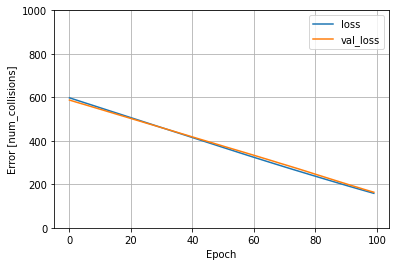

In [105]:
plot_loss(history)

In [106]:
test_results['norm_col_mod_2'] = norm_col_mod_2_model.evaluate(
    df_norm_col_mod_test_2_feat,
    df_norm_col_mod_test_2_lab, verbose=0)

In [107]:
print(test_results)

{'temp_model': 155.27452087402344, 'col_mod_1': 154.217529296875, 'std_col_mod_1': 161.0737762451172, 'norm_col_mod_1': 158.41468811035156, 'col_mod_2': 167.04177856445312, 'std_col_mod_2': 165.54393005371094, 'norm_col_mod_2': 157.43344116210938}


## Deep Neural Networks

### Build and Compile Function

In [108]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### DNN 1

#### Read Data

##### Training Data

In [109]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/std_col_dnn_1_train.csv"

raw_std_col_dnn_1_train = pd.read_csv(url)

df_std_col_dnn_1_train = raw_std_col_dnn_1_train.copy()

df_std_col_dnn_1_train = df_std_col_dnn_1_train.drop(df_std_col_dnn_1_train.columns[[0, 1]], axis=1)

df_std_col_dnn_1_train.head()

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,...,tue,wed,thu,fri,sat,sun,temp,visib,wdsp,num_collisions
0,2016,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,-0.664504,0.361002,0.110375,734
1,2016,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1.759592,0.043268,0.959699,658
2,2014,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0.943055,0.769518,-1.339692,480
3,2013,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1.070639,-1.908529,-0.055347,633
4,2013,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1.427874,-1.545404,-0.283215,550


##### Test Data

In [110]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/std_col_dnn_1_test.csv"

raw_std_col_dnn_1_test = pd.read_csv(url)

df_std_col_dnn_1_test = raw_std_col_dnn_1_test.copy()

df_std_col_dnn_1_test = df_std_col_dnn_1_test.drop(df_std_col_dnn_1_test.columns[[0, 1]], axis=1)

df_std_col_dnn_1_test.head()

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,...,tue,wed,thu,fri,sat,sun,temp,visib,wdsp,num_collisions
0,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,-0.970705,0.769518,1.042560,381
1,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,-1.123806,0.678736,-1.132539,393
2,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,-1.111048,0.224830,-0.511082,521
3,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,-0.843121,0.678736,-0.055347,513
4,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,-0.664504,0.542565,-0.635374,516


#### Check for NAs

In [111]:
df_std_col_dnn_1_train.isna().sum()

year              0
jan               0
feb               0
mar               0
apr               0
may               0
jun               0
jul               0
aug               0
sep               0
oct               0
nov               0
dec               0
mon               0
tue               0
wed               0
thu               0
fri               0
sat               0
sun               0
temp              0
visib             0
wdsp              0
num_collisions    0
dtype: int64

#### Overview Data

In [128]:
df_std_col_dnn_1_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,1766.0,2015.976784,2.006229,2013.000000,2014.000000,2016.000000,2018.000000,2019.000000
jan,1766.0,0.088335,0.283862,0.000000,0.000000,0.000000,0.000000,1.000000
feb,1766.0,0.068516,0.252702,0.000000,0.000000,0.000000,0.000000,1.000000
mar,1766.0,0.083805,0.277174,0.000000,0.000000,0.000000,0.000000,1.000000
apr,1766.0,0.090600,0.287121,0.000000,0.000000,0.000000,0.000000,1.000000
may,1766.0,0.078143,0.268472,0.000000,0.000000,0.000000,0.000000,1.000000
jun,1766.0,0.088335,0.283862,0.000000,0.000000,0.000000,0.000000,1.000000
jul,1766.0,0.083239,0.276321,0.000000,0.000000,0.000000,0.000000,1.000000
aug,1766.0,0.087769,0.283039,0.000000,0.000000,0.000000,0.000000,1.000000
sep,1766.0,0.079841,0.271124,0.000000,0.000000,0.000000,0.000000,1.000000


#### Separate Features and Labels

In [114]:
df_std_col_dnn_1_train_feat = df_std_col_dnn_1_train.copy()
df_std_col_dnn_1_test_feat = df_std_col_dnn_1_test.copy()

df_std_col_dnn_1_train_lab = df_std_col_dnn_1_train_feat.pop('num_collisions')
df_std_col_dnn_1_test_lab = df_std_col_dnn_1_test_feat.pop('num_collisions')

#### Model

##### Normaliser Layer

In [115]:
normaliser = tf.keras.layers.Normalization(axis=-1)

normaliser.adapt(np.array(df_std_col_dnn_1_train_feat))

print(normaliser.mean.numpy())

[[2015.976    0.088    0.069    0.084    0.091    0.078    0.088    0.083
     0.088    0.08     0.084    0.082    0.086    0.146    0.143    0.147
     0.147    0.145    0.134    0.139   -0.01    -0.021    0.02 ]]


##### Sequencer

In [116]:
std_col_dnn_1 = np.array(df_std_col_dnn_1_train_feat)
std_col_dnn_1_normaliser = layers.Normalization(axis=-1)
std_col_dnn_1_normaliser.adapt(np.array(df_std_col_dnn_1_train_feat))

In [119]:
std_col_dnn_1_model = build_and_compile_model(std_col_dnn_1_normaliser)

std_col_dnn_1_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_15 (Normaliza  (None, 23)               47        
 tion)                                                           
                                                                 
 dense_10 (Dense)            (None, 64)                1536      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,808
Trainable params: 5,761
Non-trainable params: 47
_________________________________________________________________


In [121]:
%%time
history = std_col_dnn_1_model.fit(
    df_std_col_dnn_1_train_feat,
    df_std_col_dnn_1_train_lab,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 12.4 s, sys: 766 ms, total: 13.2 s
Wall time: 21.3 s


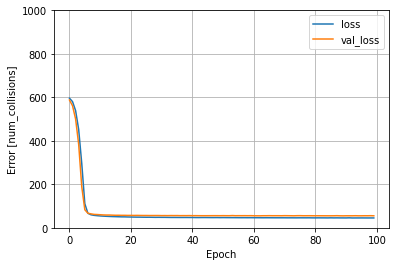

In [122]:
plot_loss(history)

In [123]:
test_results['std_col_dnn_1'] = std_col_dnn_1_model.evaluate(
    df_std_col_dnn_1_test_feat, 
    df_std_col_dnn_1_test_feat, verbose=0)

In [124]:
print(test_results)

{'temp_model': 155.27452087402344, 'col_mod_1': 154.217529296875, 'std_col_mod_1': 161.0737762451172, 'norm_col_mod_1': 158.41468811035156, 'col_mod_2': 167.04177856445312, 'std_col_mod_2': 165.54393005371094, 'norm_col_mod_2': 157.43344116210938, 'std_col_dnn_1': 640.9733276367188}


### DNN 2

#### Read Data

##### Training Data

In [125]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/std_col_dnn_2_train.csv"

raw_std_col_dnn_2_train = pd.read_csv(url)

df_std_col_dnn_2_train = raw_std_col_dnn_2_train.copy()

df_std_col_dnn_2_train = df_std_col_dnn_2_train.drop(df_std_col_dnn_2_train.columns[[0, 1]], axis=1)

df_std_col_dnn_2_train.head()

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,...,thu,fri,sat,sun,temp,visib,wdsp,slp,dewp,num_collisions
0,2016,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0.624095,0.633346,0.421103,0.888240,0.579826,523
1,2018,1,0,0,0,0,0,0,0,0,...,0,0,0,0,-1.863794,0.769518,0.897553,2.404444,-2.201736,677
2,2017,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1.695800,-1.182279,-0.676804,-0.838915,1.492857,733
3,2019,1,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.511403,-1.227670,0.648971,-2.526516,-0.280123,514
4,2016,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1.555458,-1.636185,0.110375,0.229021,1.620257,672


##### Test Data

In [126]:
url = "https://raw.githubusercontent.com/AaronM44/DAOTW-Assignment-1/main/outputs/std_col_dnn_2_test.csv"

raw_std_col_dnn_2_test = pd.read_csv(url)

df_std_col_dnn_2_test = raw_std_col_dnn_2_test.copy()

df_std_col_dnn_2_test = df_std_col_dnn_2_test.drop(df_std_col_dnn_2_test.columns[[0, 1]], axis=1)

df_std_col_dnn_2_test.head()

,year,jan,feb,mar,apr,may,jun,jul,aug,sep,...,thu,fri,sat,sun,temp,visib,wdsp,slp,dewp,num_collisions
0,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,-1.710693,0.769518,0.421103,-0.443383,-1.904470,480
1,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,-2.118962,0.769518,-0.200354,0.176283,-2.148653,549
2,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,-1.378974,0.769518,0.151805,-0.206064,-1.373638,505
3,2013,1,0,0,0,0,0,0,0,0,...,0,1,0,0,-1.123806,0.678736,-1.132539,0.387233,-0.768489,393
4,2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.830363,-0.682982,-1.277546,1.244218,-0.396906,487


#### Check for NAs

In [129]:
df_std_col_dnn_2_train.isna().sum()

year              0
jan               0
feb               0
mar               0
apr               0
may               0
jun               0
jul               0
aug               0
sep               0
oct               0
nov               0
dec               0
mon               0
tue               0
wed               0
thu               0
fri               0
sat               0
sun               0
temp              0
visib             0
wdsp              0
slp               0
dewp              0
num_collisions    0
dtype: int64

#### Overview of Data

In [130]:
df_std_col_dnn_2_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year,1766.0,2015.983012,1.996809,2013.000000,2014.000000,2016.000000,2018.000000,2019.000000
jan,1766.0,0.082673,0.275465,0.000000,0.000000,0.000000,0.000000,1.000000
feb,1766.0,0.070781,0.256532,0.000000,0.000000,0.000000,0.000000,1.000000
mar,1766.0,0.087769,0.283039,0.000000,0.000000,0.000000,0.000000,1.000000
apr,1766.0,0.078143,0.268472,0.000000,0.000000,0.000000,0.000000,1.000000
may,1766.0,0.083805,0.277174,0.000000,0.000000,0.000000,0.000000,1.000000
jun,1766.0,0.080408,0.272000,0.000000,0.000000,0.000000,0.000000,1.000000
jul,1766.0,0.090600,0.287121,0.000000,0.000000,0.000000,0.000000,1.000000
aug,1766.0,0.087203,0.282212,0.000000,0.000000,0.000000,0.000000,1.000000
sep,1766.0,0.084938,0.278868,0.000000,0.000000,0.000000,0.000000,1.000000
